## Screen Parsing

The purpose of this notebook is to experiment with the idea of using Canny edge detection along with
`knn` algorithms to devise a semantic hierarchy of screen elements that would enable users to match
on elements that are *text / subelement invariant*.
This is critical, for example, when looping over a list of buttons or dialogs that you would like to
match on, however the selection is based on relation to something in the overall hierarchy more than
it is based on the content or the appearance of the element itself.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

As a principle example we can use this image of the Sectra PACS software for a future application
that involves clicking open reports and copy-pasting from them.

![Sectra Screen](data/sectra_reportlist.png)

This is a good use case for semantic parsing.
The clickable element is on the far right where the text inside the white button can either read
`No Score` or some text describing the score.
We can't match on the button itself because then we would have to enumerate all possible variants
of that button.
We also need some kind of state tracking to determine which buttons we hit and which we have not.

Find all text in the image and remove it

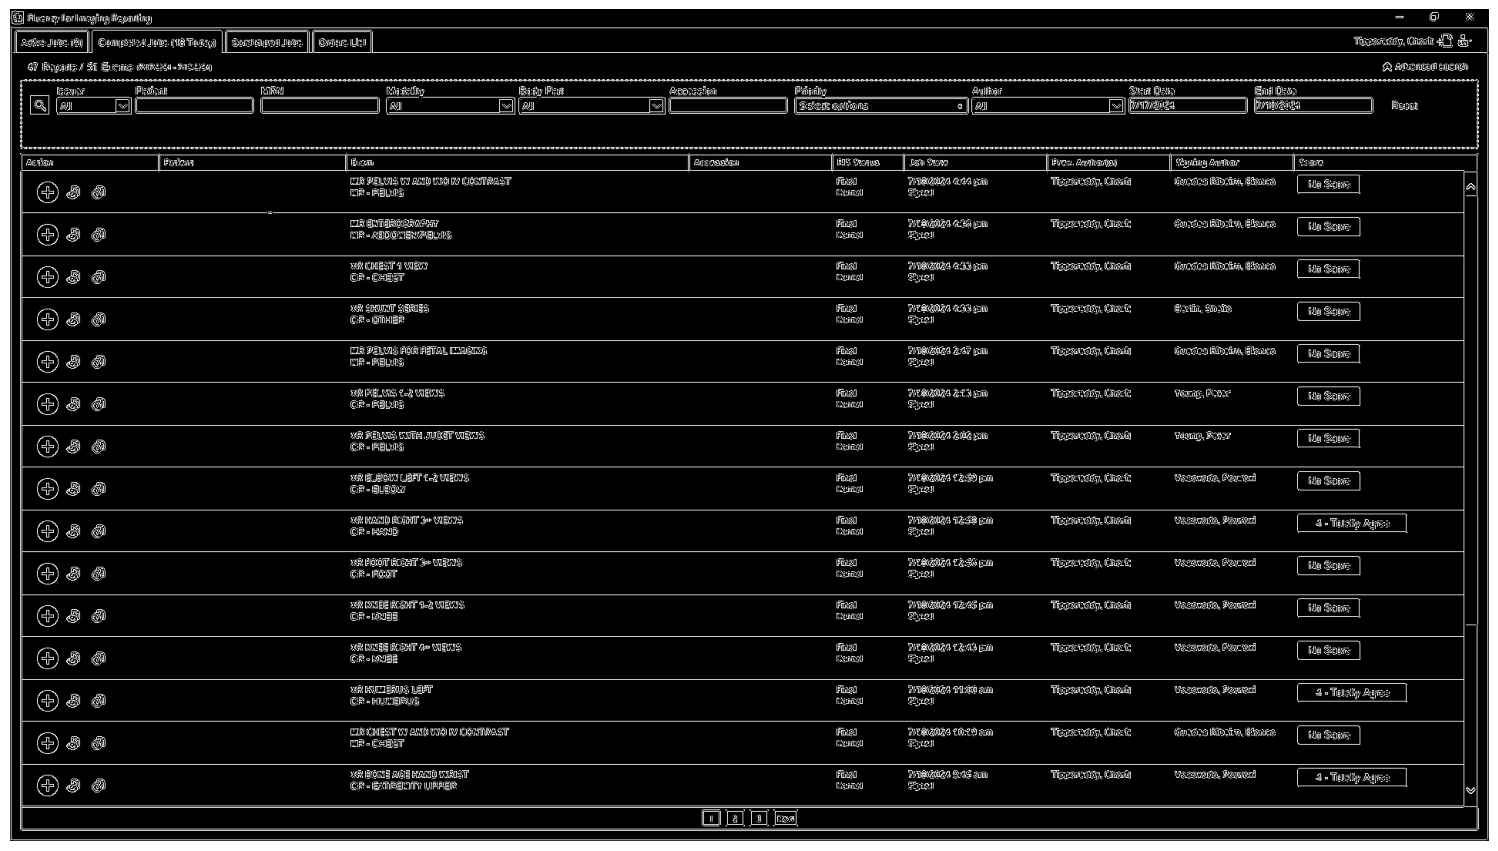

In [85]:
sectra = cv.imread("data/sectra_reportlist.png", cv.IMREAD_COLOR)
naive_edges = cv.Canny(sectra, 10, 100)
plt.figure(figsize=(1980/100, 1080/100))
plt.axis("off")
plt.imshow(naive_edges, cmap="gray")
plt.show()

### Parsing out Subregions (Rows)

Common problem: the rows parsed out using Canny share a common boundary so they can't be extracted
using connected components analysis

In [140]:
def hough_to_cartesian(lines, img_shape):
    cartesian_lines = []
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + img_shape[1] * (-b))
        y1 = int(y0 + img_shape[0] * (a))
        x2 = int(x0 - img_shape[1] * (-b))
        y2 = int(y0 - img_shape[0] * (a))
        cartesian_lines.append([(x1, y1), (x2, y2)])
    return cartesian_lines

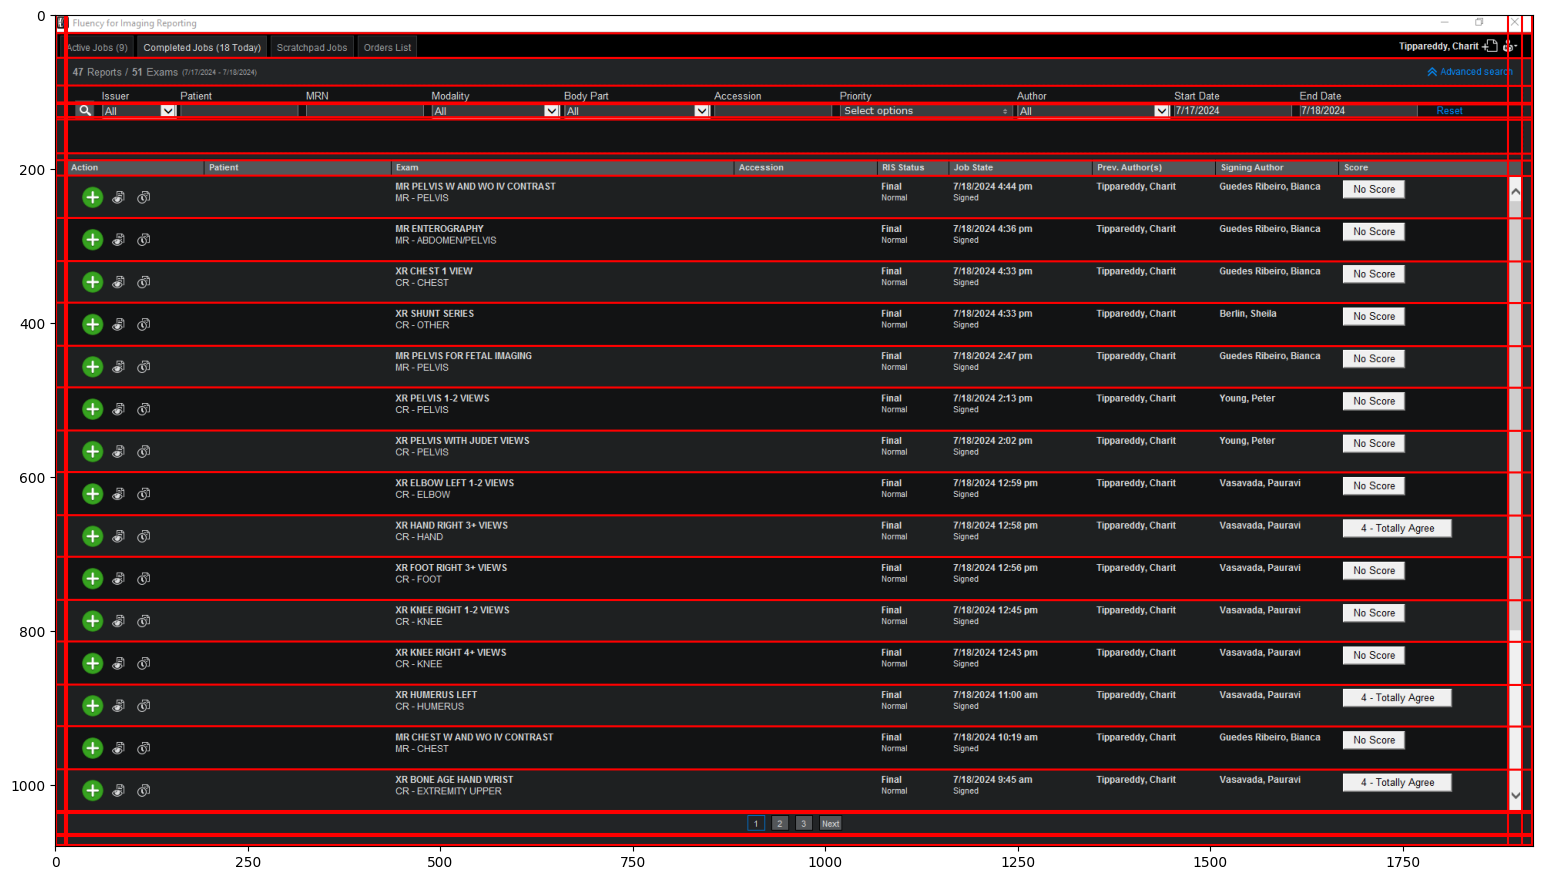

In [148]:
lines = cv.HoughLines(naive_edges, 1, np.pi / 180, 500)
cartesian_lines = hough_to_cartesian(lines, sectra.shape)

fig = plt.figure(figsize=(1980/100, 1080/100))
for line in cartesian_lines:
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], "r-")
    

plt.imshow(cv.cvtColor(sectra, cv.COLOR_BGR2RGB), cmap='gray')
plt.show()

Let's try it with another screen - this epic chart review screen - we select for specifically
the table part because that's what we would do in the actual UI when we provide it to the user.

![Epic Chart Review Table](data/epic_chart_review_table.png)

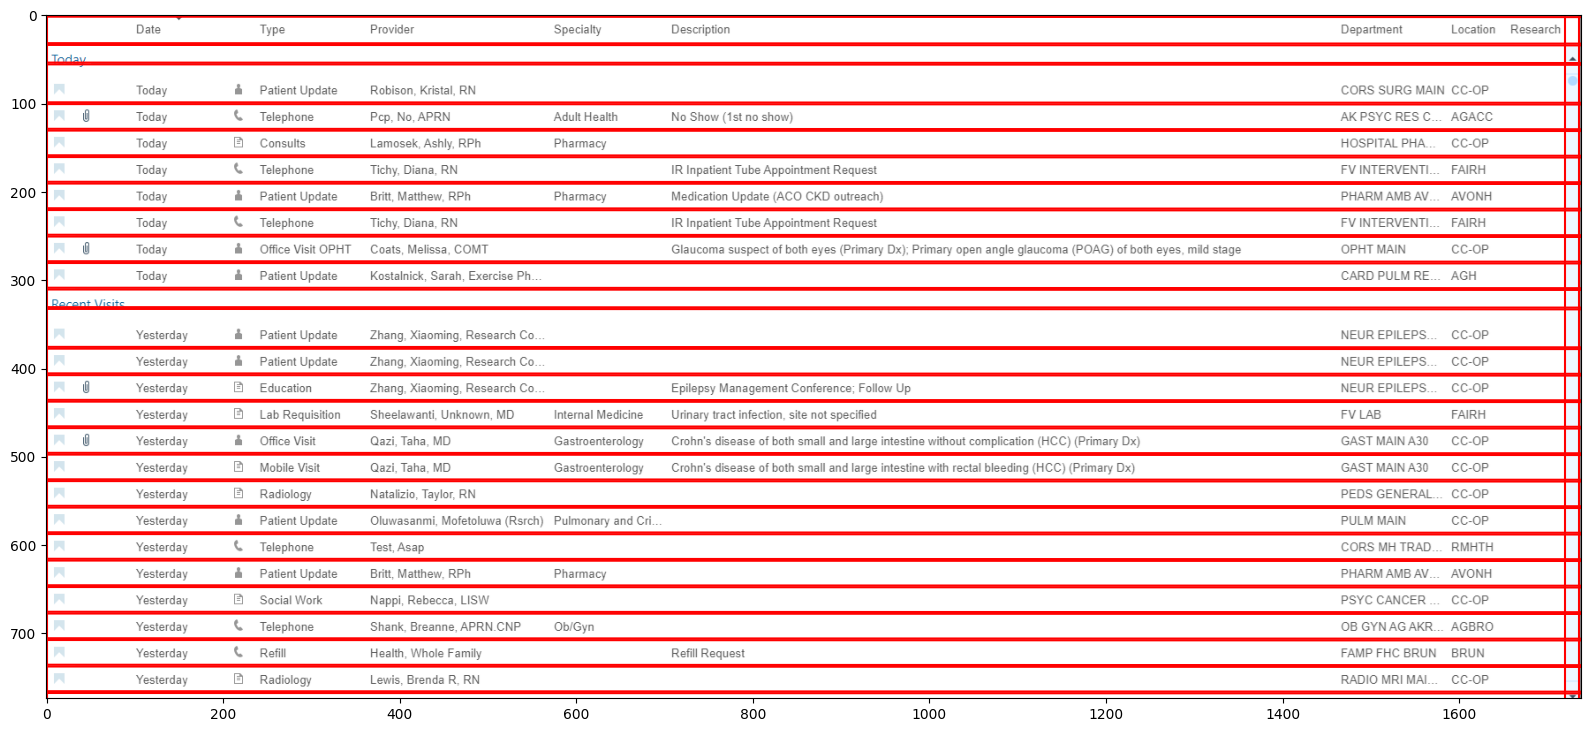

In [149]:
epic_chart_table = cv.imread("data/epic_chart_review_table.png", cv.IMREAD_COLOR)
epic_edges = cv.Canny(epic_chart_table, 10, 100)
epic_lines = cv.HoughLines(epic_edges, 1, np.pi / 180, 500)

cartesian_lines = hough_to_cartesian(epic_lines, epic_chart_table.shape)

fig = plt.figure(figsize=(1980/100, 1080/100))
for line in cartesian_lines:
    x1, y1 = line[0]
    x2, y2 = line[1]
    plt.plot([x1, x2], [y1, y2], "r-")
    

plt.imshow(cv.cvtColor(epic_chart_table, cv.COLOR_BGR2RGB), cmap='gray')
plt.show()

Next Steps:
- Define region inside rectangle as a row
- Define rows to attach to dataframe-like structure
- Map out how to use iterative scrolling to get the rest of the table structure